### Sector Rotational Momentum Trading Program with RF Classification Predicitons

The program presented here is a sector rotational momentum program which incorporates RF Classificaion predictions in addition to A_periods, B_periods, and S_periods scoring.

The ETF list evaluated is the same as in the Baseline model and is listed below:
- 'XLU'
- 'XLV'
- 'DIA'
- 'GDX'
- 'XLE'
- 'XLY'
- 'VNQ'
- 'XLK'
- 'XLF'
- 'XLP'
- 'IHI'
- 'XRT'
- 'RXI'
- 'IYW'
- 'VIS'
- 'KBE'
- 'SIL'
- 'FXU'
- 'SHY'

A combination of yfinance and WRDS ETF data is used. For A_periodss, B_periods, and S_periods scores, yahoo finance data is used, while for ML predcitions, WRDS data is used.

It is expected that classification predictions will be worse than the regression predictions due to the loss of information in the classification task with regards to correlation to the stock price. This is validated through the results below.

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 10 10:42:09 2018

@author: Bryan Tarras (modified), Rosario (original)
"""

import pandas as pd
import numpy as np
import math
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import detrendPrice
import WhiteRealityCheckFor1

import yfinance as yf
#yf.pdr_override() # <== that's all it takes :-)

In [22]:
counter_risk_stock = 0 #Superceded variable can probably be deleted
counter_risk_bond = 0 #Superceded variable can probably be deleted

In [23]:
def getDate(dt):
    if type(dt) != str:
        return dt
    try:
        datetime_object = datetime.datetime.strptime(dt, '%Y-%m-%d')
    except Exception:
        datetime_object = datetime.datetime.strptime(dt, '%m/%d/%Y')
        return datetime_object
    else:
        return datetime_object

In [4]:
#Training Data Set Data
start_date_training = '2010-01-05'
end_date_training = '2016-12-30'

#Test Data Set Data
start_date_training = '2017-01-03'
end_date_training = '2018-08-06'

### The Cells below are to download the data sets for Training and Test Sets

Need to run it to generate the proper csv files

***Only need to run this once per stock_list combination

Below is to download the training data and test data and store in csv files with the suffix "_training" or "_test"

In [5]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
end_date_training=datetime.datetime(2016, 12, 30)

start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_train.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"train.csv")

#Below is for AP test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"AP_test.csv")

#Below is for normal price test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"test.csv")



### Training Data Section
The secion bleow will read in the training data and proceed to run the trading algorithm on this training data set

In [24]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.train.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_train.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [25]:
dfP.shape

(1761, 19)

In [26]:
dfP.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,30.709999,31.299999,105.489998,48.169998,59.290001,30.110001,44.500000,23.240000,12.152721,26.680000,53.779999,18.084999,44.410000,58.400002,52.770000,22.180000,NaN,15.45,83.169998
2010-01-06,30.889999,31.620001,105.559998,49.340000,60.000000,30.150000,44.419998,22.980000,12.177092,26.660000,54.389999,18.250000,44.430000,57.990002,52.900002,22.469999,NaN,15.47,83.180000
2010-01-07,30.750000,31.730000,105.940002,49.099998,59.910000,30.400000,44.900002,22.889999,12.437043,26.660000,54.630001,18.299999,44.650002,57.770000,53.549999,23.410000,NaN,15.41,83.160004
2010-01-08,30.719999,31.780001,106.110001,49.840000,60.299999,30.389999,44.570000,23.040001,12.363932,26.570000,54.689999,18.260000,45.009998,58.209999,54.259998,23.320000,NaN,15.35,83.239998
2010-01-11,31.040001,31.959999,106.540001,50.169998,60.220001,30.330000,44.830002,22.950001,12.372055,26.639999,55.029999,18.205000,45.200001,57.930000,54.770000,23.330000,NaN,15.49,83.279999


In [27]:
dfAP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,44.442898,66.537178,186.965958,19.084234,69.879646,79.567932,72.273666,47.078487,22.429367,48.298004,132.494278,42.660793,87.801529,119.185059,115.131683,41.815819,29.729496,24.856861,80.495987
2016-12-27,44.479473,66.671288,187.116196,19.607225,70.035233,79.876732,72.425667,47.270756,22.457905,48.288719,132.752167,43.073219,87.907364,119.741531,115.351059,41.986961,30.528627,24.912346,80.457802
2016-12-28,44.058903,66.163589,186.054825,19.972334,69.275581,79.326668,71.987488,46.847755,22.229618,47.991844,131.919022,42.555294,87.532143,118.589516,114.092064,41.597141,31.082760,24.671917,80.486427
2016-12-29,44.653187,66.278542,185.970322,21.462362,69.138275,79.220520,72.881737,46.857368,22.067909,48.214500,132.216583,42.440205,87.166534,118.501640,114.120667,41.245350,33.238281,24.912346,80.572304
2016-12-30,44.406326,66.039070,185.519440,20.643339,68.936935,78.554649,73.802818,46.492046,22.115473,47.973286,132.057877,42.267570,86.743217,117.398438,113.748695,41.330914,31.604418,24.718153,80.600952


In [155]:
#Reading in the predictions from the RF model

dfRF_C_train = pd.read_csv('rf-classification-ETF-train-predictions.csv')

print (dfRF_C_train.shape)

(1761, 20)


In [151]:
#dfRF_C_train = dfRF_C_train.drop('Unnamed: 0', axis=1)

In [156]:
dfRF_C_train.set_index('Date', inplace=True)

In [157]:
dfRF_C_train.head()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0,1,1,0,2,0,1,0,0,0,2.0,0,0,0,0,0,0,1,0.0
2010-01-06,0,1,1,0,2,0,1,0,0,0,2.0,1,0,0,0,0,0,1,0.0
2010-01-07,0,1,1,0,2,0,1,0,0,0,2.0,0,0,0,0,0,0,1,0.0
2010-01-08,0,1,1,0,2,0,1,0,0,0,2.0,0,0,0,0,0,0,1,0.0
2010-01-11,0,1,1,0,2,0,1,0,0,0,2.0,0,0,0,0,0,0,0,0.0


In [158]:
dfRF_C_train.tail()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,1,1,0,1,1,2,0,1,2,2,2.0,1,0,0,2,2,1,1,NaN
2016-12-27,1,1,0,1,1,2,0,1,2,2,2.0,1,0,0,2,2,1,1,NaN
2016-12-28,1,1,0,1,1,2,0,1,2,2,NaN,1,0,0,2,2,1,1,NaN
2016-12-29,1,1,0,1,1,2,0,1,2,2,NaN,1,0,1,2,2,1,1,NaN
2016-12-30,1,1,0,1,0,2,0,1,2,2,NaN,1,0,1,1,2,1,1,NaN


In [159]:
dfRF_C_train = dfRF_C_train[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [160]:
dfRF_C_train.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0,0,0,1,0,1,2,0,0,0,0,1,0,0,0,1,0.0,0,2.0
2010-01-06,0,0,0,1,0,1,2,0,0,0,0,1,0,0,1,1,0.0,0,2.0
2010-01-07,0,0,0,1,0,1,2,0,0,0,0,1,0,0,0,1,0.0,0,2.0
2010-01-08,0,0,0,1,0,1,2,0,0,0,0,1,0,0,0,1,0.0,0,2.0
2010-01-11,0,0,0,1,0,0,2,0,0,0,0,1,0,0,0,1,0.0,0,2.0


### In the cell blocks below we need to optimize the following:
    - Aperiods
    - Bperiods
    - Speriods
    
We should run with the following parameter spread:
    - Aperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Bperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
    - Frequency = '20W-Thu'
    
Evaluation fo which ETF is to be selected will occur on the Aperiods score, Bperiods score, Speriods score, and the predictions from the RF model lagged at 20 weeks.

In [185]:
def stock_etf_optimization (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder)

Need to make a dataframe that stores annual returns, CAGR, Sharpe Ratio, Average Return, Aperiods, Bperiods, frequency 

In [186]:
Aperiods = [10, 15, 20, 30, 40, 50]
Bperiods = [10, 15, 20, 30, 40, 50]
Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
#frequency = ['8W-MON', '8W-TUE', '8W-WED', '8W-THU', '8W-FRI', '20W-MON', '20W-TUE', '20W-WED', '20W-THU', '20W-FRI', '40W-MON', '40W-TUE', '40W-WED', '40W-THU', '40W-FRI']

In [187]:
#Uncomment the below for testingpurposes only
#Aperiods = [10]
#Bperiods = [20]
#Speriods = [1]

In [188]:
df_place_holder = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','frequency'])

In [189]:
df_stock_etf_optimal_list = [[0]*6]

In [190]:
counter = 0
counter_risk_stock = 0

In [191]:
for x in Aperiods:
    for z in Bperiods:
        for y in (Speriods):
            counter = counter + 1
            test = stock_etf_optimization (x,z,y,counter_risk_stock,df_place_holder)
            df_stock_etf_optimal_list.append(test)
            print (counter)

TotaAnnReturn = 13.169121
CAGR = 9.470000
Sharpe Ratio = 0.510000
1
TotaAnnReturn = 26.655250
CAGR = 15.670000
Sharpe Ratio = 1.250000
2
TotaAnnReturn = 15.579000
CAGR = 10.740000
Sharpe Ratio = 0.830000
3
TotaAnnReturn = 7.747712
CAGR = 6.190000
Sharpe Ratio = 0.440000
4
TotaAnnReturn = 9.089533
CAGR = 7.060000
Sharpe Ratio = 0.490000
5
TotaAnnReturn = 20.425415
CAGR = 13.070000
Sharpe Ratio = 0.990000
6
TotaAnnReturn = 9.089533
CAGR = 7.060000
Sharpe Ratio = 0.490000
7
TotaAnnReturn = 14.632772
CAGR = 10.250000
Sharpe Ratio = 0.680000
8
TotaAnnReturn = 16.169536
CAGR = 11.040000
Sharpe Ratio = 0.560000
9
TotaAnnReturn = 13.007940
CAGR = 9.380000
Sharpe Ratio = 0.700000
10
TotaAnnReturn = 16.839074
CAGR = 11.380000
Sharpe Ratio = 0.740000
11
TotaAnnReturn = 7.549053
CAGR = 6.060000
Sharpe Ratio = 0.440000
12
TotaAnnReturn = 10.728384
CAGR = 8.070000
Sharpe Ratio = 0.550000
13
TotaAnnReturn = 7.498172
CAGR = 6.020000
Sharpe Ratio = 0.440000
14
TotaAnnReturn = 9.923563
CAGR = 7.580000
S

TotaAnnReturn = 7.523417
CAGR = 6.040000
Sharpe Ratio = 0.410000
120
TotaAnnReturn = 26.293438
CAGR = 15.530000
Sharpe Ratio = 0.690000
121
TotaAnnReturn = 1.251111
CAGR = 1.170000
Sharpe Ratio = 0.170000
122
TotaAnnReturn = 8.507807
CAGR = 6.690000
Sharpe Ratio = 0.460000
123
TotaAnnReturn = 4.729473
CAGR = 4.050000
Sharpe Ratio = 0.310000
124
TotaAnnReturn = 8.630375
CAGR = 6.770000
Sharpe Ratio = 0.440000
125
TotaAnnReturn = 14.028792
CAGR = 9.930000
Sharpe Ratio = 0.640000
126
TotaAnnReturn = 7.294023
CAGR = 5.880000
Sharpe Ratio = 0.390000
127
TotaAnnReturn = 7.552437
CAGR = 6.060000
Sharpe Ratio = 0.400000
128
TotaAnnReturn = 26.709128
CAGR = 15.690000
Sharpe Ratio = 0.700000
129
TotaAnnReturn = -1.526892
CAGR = -1.560000
Sharpe Ratio = 0.060000
130
TotaAnnReturn = 7.981340
CAGR = 6.340000
Sharpe Ratio = 0.430000
131
TotaAnnReturn = 6.151861
CAGR = 5.090000
Sharpe Ratio = 0.350000
132
TotaAnnReturn = 18.875611
CAGR = 12.360000
Sharpe Ratio = 0.730000
133
TotaAnnReturn = 11.989679

TotaAnnReturn = 7.320625
CAGR = 5.900000
Sharpe Ratio = 0.420000
238
TotaAnnReturn = 7.873915
CAGR = 6.270000
Sharpe Ratio = 0.440000
239
TotaAnnReturn = 6.694606
CAGR = 5.470000
Sharpe Ratio = 0.400000
240
TotaAnnReturn = 26.709128
CAGR = 15.690000
Sharpe Ratio = 0.700000
241
TotaAnnReturn = 9.806377
CAGR = 7.510000
Sharpe Ratio = 0.480000
242
TotaAnnReturn = 13.333421
CAGR = 9.560000
Sharpe Ratio = 0.620000
243
TotaAnnReturn = 6.790653
CAGR = 5.540000
Sharpe Ratio = 0.380000
244
TotaAnnReturn = 5.601252
CAGR = 4.690000
Sharpe Ratio = 0.340000
245
TotaAnnReturn = 4.972771
CAGR = 4.230000
Sharpe Ratio = 0.320000
246
TotaAnnReturn = 6.525139
CAGR = 5.350000
Sharpe Ratio = 0.370000
247
TotaAnnReturn = 5.936434
CAGR = 4.940000
Sharpe Ratio = 0.350000
248
TotaAnnReturn = 28.852009
CAGR = 16.500000
Sharpe Ratio = 0.720000
249
TotaAnnReturn = 4.472075
CAGR = 3.850000
Sharpe Ratio = 0.290000
250
TotaAnnReturn = 1.967503
CAGR = 1.810000
Sharpe Ratio = 0.200000
251
TotaAnnReturn = 5.521284
CAGR

In [192]:
df_stock_etf_optimal=pd.DataFrame(df_stock_etf_optimal_list,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [193]:
print (df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
81       32.643199  17.86          0.76        15        40         1   
201      32.643199  17.86          0.76        40        15         1   
73       30.588373  17.14          0.74        15        30         1   
153      30.588373  17.14          0.74        30        15         1   
89       28.852009  16.50          0.72        15        50         1   
249      28.852009  16.50          0.72        50        15         1   
225      27.899632  16.15          0.71        40        40         1   
57       27.271246  15.91          0.69        15        15         1   
281      27.023241  15.81          0.68        50        50         1   
177      26.942593  15.78          0.70        30        40         1   
217      26.942593  15.78          0.70        40        30         1   
33       26.709128  15.69          0.70        10        40         1   
41       26.709128  15.69          0.70        10  

In [194]:
print (df_stock_etf_optimal.nlargest(50, 'Sharpe Ratio'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
2        26.655250  15.67          1.25        10        10         5   
62       24.991056  15.01          1.02        15        15        25   
136      26.706701  15.69          1.02        20        40        35   
216      26.706701  15.69          1.02        40        20        35   
64       23.806164  14.52          1.00        15        15        35   
6        20.425415  13.07          0.99        10        10        25   
61       23.738128  14.50          0.99        15        15        20   
78       24.289606  14.72          0.86        15        30        25   
158      24.289606  14.72          0.86        30        15        25   
3        15.579000  10.74          0.83        10        10        10   
26       21.466026  13.53          0.83        10        30         5   
146      21.466026  13.53          0.83        30        10         5   
77       22.357368  13.91          0.82        15  

The line below is for outputting results to a csv file.

In [195]:
df_stock_etf_optimal.to_csv('APS1052_df_stock_etf_optimal_training_results_top_one_with_prediction_RF_Classification.csv', header = True, index=True, encoding='utf-8')

#### Okay the next step is to use the optimal parameters from the training data identified above to plot an equity curve for the stock etfs

In [19]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.train.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_train.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [196]:
def stock_etf_optimized_parameters():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 15 #20 Default
    Bperiods = 40 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return (stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5)

Number of times "XLU" is selected 0.000000 
Number of times "XLV" is selected 367.000000 
Number of times "DIA" is selected 88.000000 
Number of times "GDX" is selected 250.000000 
Number of times "XLE" is selected 191.000000 
Number of times "XLY" is selected 66.000000 
Number of times "VNQ" is selected 99.000000 
Number of times "XLK" is selected 40.000000 
Number of times "XLF" is selected 228.000000 
Number of times "XLP" is selected 61.000000 
Number of times "IHI" is selected 6.000000 
Number of times "XRT" is selected 22.000000 
Number of times "RXI" is selected 14.000000 
Number of times "IYW" is selected 1.000000 
Number of times "VIS" is selected 12.000000 
Number of times "KBE" is selected 21.000000 
Number of times "SIL" is selected 71.000000 
Number of times "FXU" is selected 6.000000 
Number of times "SHY" is selected 218.000000 


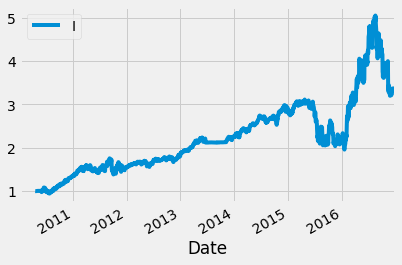

TotaAnnReturn = 32.643199
CAGR = 17.860000
Sharpe Ratio = 0.760000
Standard Deviation = 0.018292


In [197]:
stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5 = stock_etf_optimized_parameters()

### Performance on test data set

What we want to do is take that df_stock_etf_optimal dataframe, extract the top 50 parameter combinations on the training data and run it on the test data to see which combinations performs best. Use the best as the total portfolio parameters to be used on the entire dataset.

In [198]:
df_stock_optimal_training_results = df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn')
df_stock_optimal_training_results = df_stock_optimal_training_results.drop(['TotaAnnReturn', 'CAGR', 'Sharpe Ratio'], axis = 1)

In [199]:
df_stock_optimal_training_results = df_stock_optimal_training_results.reset_index(drop = True) 

In [200]:
df_stock_optimal_training_results.head(100)

,Aperiods,Bperiods,Speriods,Frequency
0,15,40,1,20W-THU
1,40,15,1,20W-THU
2,15,30,1,20W-THU
3,30,15,1,20W-THU
4,15,50,1,20W-THU
5,50,15,1,20W-THU
6,40,40,1,20W-THU
7,15,15,1,20W-THU
8,50,50,1,20W-THU
9,30,40,1,20W-THU


In [201]:
Aperiods_training = []
Bperiods_training = []
Speriods_training = []

clm = list(df_stock_optimal_training_results)
for x in range (0,50):
    Aperiods_training.append(df_stock_optimal_training_results['Aperiods'][x])
    Bperiods_training.append(df_stock_optimal_training_results['Bperiods'][x])
    Speriods_training.append(df_stock_optimal_training_results['Speriods'][x])

print (Aperiods_training, Bperiods_training, Speriods_training)

[15, 40, 15, 30, 15, 50, 40, 15, 50, 30, 40, 10, 10, 20, 40, 40, 50, 20, 40, 10, 20, 30, 30, 15, 15, 30, 15, 20, 15, 15, 20, 50, 15, 30, 10, 30, 15, 30, 30, 40, 15, 40, 30, 50, 10, 40, 50, 10, 40, 20] [40, 15, 30, 15, 50, 15, 40, 15, 50, 40, 30, 40, 50, 40, 10, 20, 10, 40, 20, 10, 30, 20, 30, 15, 30, 15, 20, 15, 15, 15, 50, 20, 30, 15, 30, 10, 30, 15, 40, 30, 40, 15, 50, 30, 10, 50, 40, 40, 10, 40] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 35, 35, 5, 1, 1, 1, 25, 25, 25, 1, 1, 35, 20, 1, 1, 20, 20, 5, 5, 35, 35, 35, 35, 25, 25, 1, 1, 25, 1, 1, 35, 35, 20]


With the best 50 results from the training data set stored in the respective lists Aperiods_training, Bperiods_training, and frequency_training, the function below will be called to iterate over these combinations to determine perfromane on the test data set.

In [233]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.test.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_test.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [234]:
print (dfP.shape)
print (dfAP.shape)

(402, 19)
(402, 19)


In [235]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [236]:
print (dfP.shape)
print (dfAP.shape)

(401, 19)
(401, 19)


In [237]:
dfP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,52.450001,88.949997,253.110001,21.110001,76.050003,110.720001,82.519997,71.559998,27.950001,53.119999,208.710007,49.049999,116.129997,184.350006,143.289993,48.580002,27.25,26.129999,83.059998
2018-08-02,52.709999,89.279999,253.100006,20.940001,75.629997,111.480003,82.190002,72.459999,27.959999,53.660000,210.380005,49.560001,116.209999,187.070007,143.289993,49.009998,26.90,26.379999,83.110001
2018-08-03,53.299999,89.809998,254.389999,21.160000,75.239998,111.860001,83.080002,72.720001,28.120001,54.290001,210.160004,49.990002,116.769997,187.710007,143.479996,48.860001,27.23,26.590000,83.120003
2018-08-06,53.340000,89.970001,254.850006,20.900000,75.519997,112.610001,82.970001,73.110001,28.270000,54.340000,210.559998,50.290001,116.620003,189.210007,143.789993,48.900002,26.90,27.059999,83.139999
2018-08-07,53.259998,89.980003,256.119995,20.660000,76.080002,113.129997,82.820000,73.389999,28.400000,54.009998,210.270004,50.709999,117.730003,189.639999,144.770004,49.040001,26.84,27.030001,83.110001


In [238]:
#Reading in the predictions from the RF model

dfRF_test = pd.read_csv('rf-classification-ETF-predictions.csv')

print (dfRF_test.shape)

(401, 20)


In [239]:
dfRF_test.set_index('Date', inplace=True)

In [240]:
dfRF_test = dfRF_test[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [214]:
dfRF_test.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2017-01-04,2,1,1,1,0,1,0,1,1,2,2,0,1,1,1,0,0.0,0,2
2017-01-05,2,0,1,1,0,0,0,1,1,2,2,0,1,1,1,0,0.0,0,2
2017-01-06,2,0,1,1,0,0,0,1,1,2,2,0,1,1,1,0,0.0,0,2
2017-01-09,2,0,1,1,0,0,1,1,1,2,2,0,1,1,1,0,0.0,0,2
2017-01-10,2,0,1,1,0,0,1,1,1,2,2,0,1,1,1,0,0.0,0,2


In [215]:
def stock_etf_performance_test_set (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder_test_performance):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder_test_performance = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder_test_performance)

In [216]:
df_place_holder_test_performance = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','frequency'])

df_stock_etf_test_performance = [[0]*6]

In [217]:
# CHANGE THE 2 BELOW TO 50 ONCE UP AND RUNNING, AND THE 1 TO A 0
for x in range (0,50):
    test_Aperiods = df_stock_optimal_training_results['Aperiods'][x]
    test_Bperiods = df_stock_optimal_training_results['Bperiods'][x]
    test_Speriods = df_stock_optimal_training_results['Speriods'][x]
    counter = counter + 1
    test = stock_etf_performance_test_set (test_Aperiods,test_Bperiods,test_Speriods,counter_risk_stock,df_place_holder_test_performance)
    df_stock_etf_test_performance.append(test)
    print (counter)
    

TotaAnnReturn = 4.778463
CAGR = 4.580000
Sharpe Ratio = 0.420000
289
TotaAnnReturn = 4.778463
CAGR = 4.580000
Sharpe Ratio = 0.420000
290
TotaAnnReturn = 13.510637
CAGR = 12.620000
Sharpe Ratio = 1.410000
291
TotaAnnReturn = 13.510637
CAGR = 12.620000
Sharpe Ratio = 1.410000
292
TotaAnnReturn = 6.458384
CAGR = 6.160000
Sharpe Ratio = 0.530000
293
TotaAnnReturn = 6.458384
CAGR = 6.160000
Sharpe Ratio = 0.530000
294
TotaAnnReturn = 9.466239
CAGR = 8.940000
Sharpe Ratio = 0.710000
295
TotaAnnReturn = 4.778463
CAGR = 4.580000
Sharpe Ratio = 0.420000
296
TotaAnnReturn = 13.878602
CAGR = 12.950000
Sharpe Ratio = 1.210000
297
TotaAnnReturn = 11.508090
CAGR = 10.810000
Sharpe Ratio = 1.050000
298
TotaAnnReturn = 11.508090
CAGR = 10.810000
Sharpe Ratio = 1.050000
299
TotaAnnReturn = 5.946762
CAGR = 5.680000
Sharpe Ratio = 0.710000
300
TotaAnnReturn = 5.946762
CAGR = 5.680000
Sharpe Ratio = 0.710000
301
TotaAnnReturn = 11.508090
CAGR = 10.810000
Sharpe Ratio = 1.050000
302
TotaAnnReturn = 5.9467

In [218]:
print (df_stock_etf_test_performance)

[[0, 0, 0, 0, 0, 0], [4.778463311531253, 4.58, 0.42, 15, 40, 1, '20W-THU'], [4.778463311531253, 4.58, 0.42, 40, 15, 1, '20W-THU'], [13.510637124486491, 12.620000000000001, 1.41, 15, 30, 1, '20W-THU'], [13.510637124486491, 12.620000000000001, 1.41, 30, 15, 1, '20W-THU'], [6.458384280662253, 6.16, 0.53, 15, 50, 1, '20W-THU'], [6.458384280662253, 6.16, 0.53, 50, 15, 1, '20W-THU'], [9.466239240455565, 8.94, 0.71, 40, 40, 1, '20W-THU'], [4.778463311531253, 4.58, 0.42, 15, 15, 1, '20W-THU'], [13.878601630855739, 12.950000000000001, 1.21, 50, 50, 1, '20W-THU'], [11.508089619914195, 10.81, 1.05, 30, 40, 1, '20W-THU'], [11.508089619914195, 10.81, 1.05, 40, 30, 1, '20W-THU'], [5.946762071511652, 5.680000000000001, 0.71, 10, 40, 1, '20W-THU'], [5.946762071511652, 5.680000000000001, 0.71, 10, 50, 1, '20W-THU'], [11.508089619914195, 10.81, 1.05, 20, 40, 1, '20W-THU'], [5.946762071511652, 5.680000000000001, 0.71, 40, 10, 1, '20W-THU'], [11.508089619914195, 10.81, 1.05, 40, 20, 1, '20W-THU'], [5.9467

In [219]:
df_stock_etf_optimal_test_results=pd.DataFrame(df_stock_etf_test_performance,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [220]:
print (df_stock_etf_optimal_test_results.nlargest(50, 'TotaAnnReturn'))

    TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods Frequency
33      18.038684  16.64          1.57        15        30        20   20W-THU
34      18.038684  16.64          1.57        30        15        20   20W-THU
41      16.637413  15.41          1.28        15        40        25   20W-THU
42      16.637413  15.41          1.28        40        15        25   20W-THU
23      14.483607  13.49          1.32        30        30         1   20W-THU
24      14.483024  13.49          1.15        15        15        25   20W-THU
30      14.483024  13.49          1.15        15        15        20   20W-THU
29      14.073861  13.13          1.16        15        15        35   20W-THU
37      13.896218  12.97          1.21        15        30        35   20W-THU
38      13.896218  12.97          1.21        30        15        35   20W-THU
9       13.878602  12.95          1.21        50        50         1   20W-THU
3       13.510637  12.62          1.41        15    

In [221]:
df_stock_etf_optimal_test_results.to_csv('df_stock_etf_optimal_test_results_top_50_training_results_on_test_data_Top_1_ETFs_RF_Classification.csv', header = True, index=True, encoding='utf-8')

With the best performing parameter combination from the training set on the test set identified, lets see the equity curve for the combination that performs best in both sets. To determine this offline analysis of the two outputted CSV files occured. After reviewing the two lists the best parameter combination was found to be:
- Aperiods = 50
- Bperiods = 50
- Speriods = 1

Finally we will run it across the entire dataset (training + test) with optimized parameters to get a annual return and sharpe ratio for the 2010-2019 data.

Start with loading the test set.

In [222]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.test.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_test.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [241]:
def stock_etf_optimized_parameters_test_set():  
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 50 #20 Default
    Bperiods = 50 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 3.000000 
Number of times "XLV" is selected 14.000000 
Number of times "DIA" is selected 33.000000 
Number of times "GDX" is selected 31.000000 
Number of times "XLE" is selected 35.000000 
Number of times "XLY" is selected 6.000000 
Number of times "VNQ" is selected 6.000000 
Number of times "XLK" is selected 37.000000 
Number of times "XLF" is selected 103.000000 
Number of times "XLP" is selected 0.000000 
Number of times "IHI" is selected 3.000000 
Number of times "XRT" is selected 12.000000 
Number of times "RXI" is selected 2.000000 
Number of times "IYW" is selected 23.000000 
Number of times "VIS" is selected 0.000000 
Number of times "KBE" is selected 0.000000 
Number of times "SIL" is selected 0.000000 
Number of times "FXU" is selected 7.000000 
Number of times "SHY" is selected 86.000000 


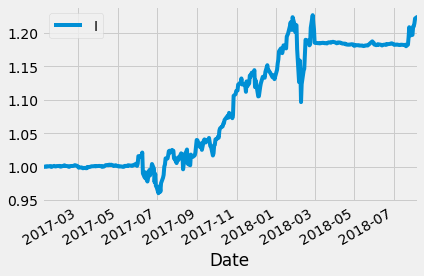

TotaAnnReturn = 13.878602
CAGR = 12.950000
Sharpe Ratio = 1.210000
Standard Deviation = 0.006967


In [242]:
testing = stock_etf_optimized_parameters_test_set()

Same parameters on whole dataset for trading program which selects only the top ETF for investment.

In [225]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
#end_date_training=datetime.datetime(2016, 12, 30)

#start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_whole.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"whole.csv")

In [243]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.whole.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_whole.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [244]:
print(dfP.shape)
print(dfAP.shape)

(2163, 19)
(2163, 19)


In [245]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [246]:
#Reading in the predictions from the RF model

dfRF_total = pd.read_csv('rf-classification-ETF-train-predictions-whole.csv')

print (dfRF_total.shape)

(2162, 20)


In [247]:
dfRF_total.set_index('Date', inplace=True)

In [248]:
dfRF_total = dfRF_total[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [249]:
dfRF_total.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,2,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,NaN,1,2.0
2018-08-02,2,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,NaN,2,2.0
2018-08-03,2,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,NaN,1,2.0
2018-08-06,2,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,NaN,2,2.0
2018-08-07,2,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,NaN,1,2.0


In [250]:
def stock_etf_optimized_parameters_full_dataset_top_ETF_only():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 50 #20 Default
    Bperiods = 50 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_total.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_total.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(.25)
    

    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    
    
    

    
    #dfAll_ranks.to_csv('dfAll_ranks.csv', header = True, index=True, encoding='utf-8')
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        
        three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            #dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 51.000000 
Number of times "XLV" is selected 188.000000 
Number of times "DIA" is selected 205.000000 
Number of times "GDX" is selected 78.000000 
Number of times "XLE" is selected 165.000000 
Number of times "XLY" is selected 176.000000 
Number of times "VNQ" is selected 146.000000 
Number of times "XLK" is selected 111.000000 
Number of times "XLF" is selected 193.000000 
Number of times "XLP" is selected 59.000000 
Number of times "IHI" is selected 173.000000 
Number of times "XRT" is selected 114.000000 
Number of times "RXI" is selected 26.000000 
Number of times "IYW" is selected 102.000000 
Number of times "VIS" is selected 19.000000 
Number of times "KBE" is selected 92.000000 
Number of times "SIL" is selected 140.000000 
Number of times "FXU" is selected 69.000000 
Number of times "SHY" is selected 55.000000 


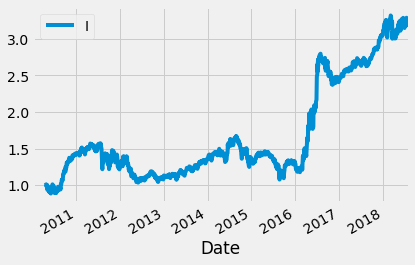

TotaAnnReturn = 26.353656
CAGR = 14.240000
Sharpe Ratio = 0.750000
Standard Deviation = 0.014330


In [251]:
testing_4 = stock_etf_optimized_parameters_full_dataset_top_ETF_only()